# Constructing phylogenetic trees using Maximum Likelihood
This Jupyter notebook is created as a project in the Algorithms in Bioinformatics course 2018 given by [Swedish National Graduate School in Medical Bioinformatics](http://www.medbioinfo.se/).   

Let's begin by importing the nessecary packages that we will using this tutorial and adding some plotting functions that we need later.

In [177]:
import numpy as np
import math
from scipy import optimize
import dendropy
import random 
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import Phylo
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import pylab
import io
import warnings; warnings.simplefilter('ignore')
import pandas as pd
random.seed(1)

In [5]:
def plot_unrooted_tree(tree):
    handle = io.StringIO(str(tree))
    tree_nwk = Phylo.read(handle, 'newick')
    for idx, clade in enumerate(tree_nwk.find_clades()):  # name the inner nodes
        if not clade.name:
            clade.name = 'Inner' + str(idx)
        
    net = Phylo.to_networkx(tree_nwk)
    pos = graphviz_layout(net)
    e_color = 'black'
    node_sizes = []
    labels = {}
    node_colors = []

    for n in list(net.nodes(data=True)):
        label = str(n[0])
        if 'Inner' in label:
            node_sizes.append(1)
            labels[n[0]] = ''
            node_colors.append(e_color)
        else:
            node_sizes.append(240)
            labels[n[0]] = label
            node_colors.append('r')
    nx.draw(net, pos,edge_color=e_color,node_size = node_sizes, labels=labels, with_labels=True,node_color=node_colors) 
    
    pylab.show()

In [6]:
def plot_rooted_tree(tree, node_probs):
    G = nx.DiGraph()
    
    for node in tree.preorder_node_iter():
        attr_dict = {}
        attr_dict['names'] = str(node.taxon)
        G.add_node(node)
        if node != tree.seed_node:
            G.add_edge(node, node.parent_node)
            
    labels = {}
    for n in list(G.nodes(data=True)):
        labels[n[0]] = str(n[0].taxon).replace("'", "")
        
        
    pos = graphviz_layout(G, prog='dot')
    nx.draw(G, pos, labels=labels, arrows=True)
    for n in list(G.nodes(data=True)):
        x, y = pos[n[0]]
        if n[0] in node_probs.keys():
            plt.text(x + 100,y - 20,s=node_probs[n[0]], bbox=dict(facecolor='red', alpha=0.2))
    pylab.show()

### Multiple Sequence Alignment
The first step in creating a phylogenetic tree is to do a multiple sequence alignment (MSA) of the sequences that we want to include in our tree. This is done to find [homologous](https://en.wikipedia.org/wiki/Sequence_homology) posititions in the sequences, that is finding positions that have a shared ancestry. There are many  different tools for doing this, but the most common ones are [ClustalW](https://www.ebi.ac.uk/Tools/msa/clustalo/), [MUSCLE](https://www.ebi.ac.uk/Tools/msa/muscle/) and [MAFFT](https://www.ebi.ac.uk/Tools/msa/mafft/).
An MSA can be represented in many different ways and there are many different file formats for storing MSAs. The most common way is that each row represent a sequnce in the alignment and each column represent a position in the alignment. If the alignment was done on the protein level each cell will contain either an ammino acid or a deletion sign, usually a -. In python we can represent an MSA as a dictionary where each key is the sequence identifier and each value is a list containing the element at each position in the alignment.


In [256]:
def read_msa(path, length):
    """
    Read a multiple sequence alignment (MSA) in fasta format
    and returns a dictionary where each key is the sequence
    identifier and each value is a list with the elements
    of the alignmnent.
    
    Args:
    path (str) - Path to the fasta file.
    
    Return:
    msa (dict) - The MSA in a dictionary
    """
    msa = {}
    with open(path, 'r') as fasta_file:
        lines = fasta_file.readlines()
        for i in range(len(lines)):
            if lines[i][0] == '>':
                seq_id = lines[i].split(" ")[0].strip()
                msa[seq_id] = ''
            else:
                alignment = lines[i].strip()
                msa[seq_id] += alignment
    
    if length != 'full':
        for k in msa:
            sub_aln = msa[k][0:length]
            msa[k] = sub_aln
    
    return msa

Now we can read the alignment and take a look at how the dictionary looks like

In [93]:
alignment = read_msa('./data/msa.fasta')
print(alignment)

{'F': 'ATGTTTAAGATAT', 'D': 'ATGCGTTAGTTTG', 'B': 'ATGGCTAAGAGTT', 'A': 'ATGGGTAAGATTG', 'E': 'ATGGCTAAGATAT', 'C': 'ATGCGTTAGAGTT'}


### Jukes and Cantor model
We will use the simplest model for sequence evolution, the Jukes-Cantor model. This assume that the equilibrium rate for all sequences are the same, 0.25, and that the probability of changing from one nucleotide to another is the same for all nucleotides. It can be shown that the probability to observe a mutation at a site is

$\frac{1}{4} + \frac{3}{4} * \exp^{\frac{-4}{3}d}$

where d is the number of substitutions per site and we can also show that the probability to observe no mutation at a site is

$\frac{1}{4} * (1-\exp{\frac{-4}{3}d})$

In the ML-setting we seek to maximize these probabilities given 

The two different functions are implemented below.

In [94]:
def prob_no_mutation_jc(distance):
    """
    Calculate the probability to not observe a mutation for a given distance using Jukes-Cantor model
    
    Parameters:
    distance - 
    """
    prob = (1/4) + (3*np.exp((-4/3) * distance))/4
    return prob

In [95]:
def prob_mutation_jc(distance):
    """
    Calculate the probability to observe a mutation for a given distance using Jukes-Cantor model.
    
    Parameters:
    distance - 
    """
    prob = (1/4) * (1 - np.exp((-4/3) * distance))
    return prob

### Trees
Now we have read an alignment, next we need trees. The number of possible unrooted trees are growing very fast, we can calculate the number of 

$\frac{(2n-3)!}{2^{n-2}(n-2)!}$

To get a feeling for how many trees there are we can write a function to calculate the number of trees given the number of taxa and this plot the relationship.

In [11]:
def number_of_trees(n_taxa):
    """
    Calculate the number of possible unrooted trees
    for a given number of taxa
    
    Paramenters:
    n_taxa (int) - number of taxa
    
    Return
    number of possible unrooted trees
    """
    trees =  math.factorial(2*n_taxa - 3) / (2 ** (n_taxa - 2) * math.factorial(n_taxa-2))
    return trees

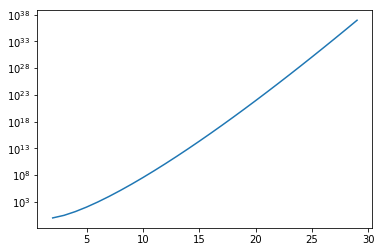

In [12]:
taxas = np.arange(2,30)
f = np.vectorize(number_of_trees)
fig, ax = plt.subplots()
sns.lineplot(x=taxas, y=f(taxas))
ax.set(yscale="log")
plt.show()

For 9 taxa there are 2,027,025 trees, adding one taxa we instead have 34,459,425 different trees. In this tutorial we assume that the number of taxa in the alignment are fewer then 6-7, then it's possible to evaluate all different trees. For a larger number of taxa it's not possible to examine all trees and we need to use heuristic methods to find the best tree.

Next step is to create a function that will create the topology for all different trees from the list of taxa. To do this we can use the python package [dendropy](https://dendropy.org/) for handling the underlying tree data structure. This is great because then we will already have built-in functions for adding and removing nodes, get children and parents to nodes, and also we can write the tree to a newick string, this makes it possible for us to plot the tree.

We can build all possible trees starting from a root that is conected to three taxa. From this we can then add one taxa to the tree by adding it to each branch in the original tree and save each new tree. For the next taxa, we take the tree new trees, and for each tree we add the new taxa to all edges on that three, and save each new tree. After this round we will have fifteen different trees. We continue this process untill all taxa have been added. In this function we set all branch length to the same distance, 0.5.

In [53]:
def create_all_trees(taxons):
    """
    Generate all possible trees by first creating a tree with a root
    and three terminal taxa. For each remaining taxa, each edge in the
    tree is split and a new taxa is inserted as a terminal node.
    
    Parameters:
    taxons = list of taxa
    
    Return
    tree_list = list with all possible trees
    """
    taxon_list = taxons
    taxon_namespace = dendropy.TaxonNamespace(taxon_list)
    init_tree = dendropy.Tree(taxon_namespace=taxon_namespace)
    
    ch1 = init_tree.seed_node.new_child(edge_length=0.1)
    ch2 = init_tree.seed_node.new_child(edge_length=0.1)
    ch3 = init_tree.seed_node.new_child(edge_length=0.1)

    ch1.taxon = taxon_namespace.get_taxon(taxon_list[0])
    ch2.taxon = taxon_namespace.get_taxon(taxon_list[1])
    ch3.taxon = taxon_namespace.get_taxon(taxon_list[2])

    tree_list = [init_tree.extract_tree()]
    for taxa in taxon_list[3:]:
        new_tree_list = []
        for tree in tree_list:
            node_list = list(tree.levelorder_node_iter())
            for node in node_list:
                children = list(node.child_nodes())
                for i,child in enumerate(children):
                    removed_node = node.remove_child(child)
                    internal_node = node.new_child(edge_length=0.1)
                    internal_node.add_child(removed_node)


                    new_taxa = internal_node.new_child(edge_length=0.1)
                    new_taxa.taxon = taxon_namespace.get_taxon(taxa)
                    new_tree_list.append(tree.extract_tree())
                    node.remove_child(internal_node)
                    node.add_child(removed_node)
        tree_list = new_tree_list

    return tree_list

This function can be tested by creating the three possible unrooted trees that can be obtained from three taxa

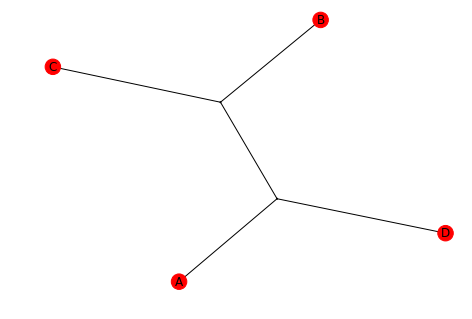

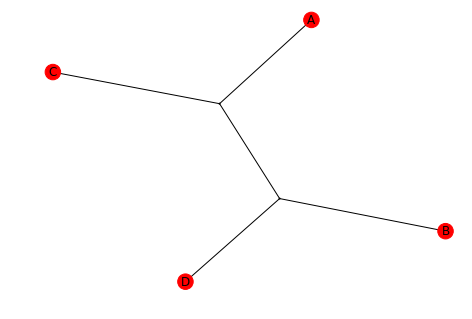

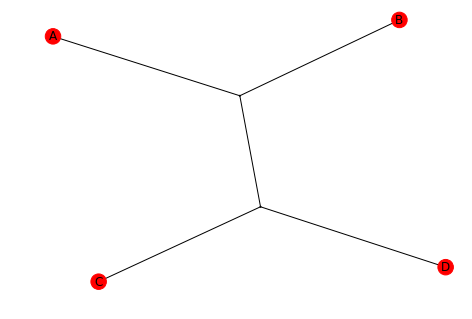

In [14]:
test_taxa = ["A", "B", "C", "D"]
trees = create_all_trees(test_taxa)
for tree in trees:
    plot_unrooted_tree(tree)

Now we have an alignment and we have a function to create all the trees and it's time to find the likelihood for the tree. We will start to assign the probabilities for observing a specific nucleotide at a specific site in each node. We start with the easiest nodes, the leaves. For these nodes we actually have the observations from the alignment. So for each leaf node we create a matrix with the size 4 x alignment length, We loop over each position and set the element in the matrix corresponding to the observed nucleotide to 1, the others are kept at 0.

In [110]:
def set_nucleotide_probs(node, node_probs, seq):
    nucl_map = {'A':0, 'C':1, 'G':2, 'T':3}
    nucl_prob = np.zeros((4, len(seq)))
    for index, nucleotide in enumerate(seq):
        if nucleotide == '-':
            x = np.ones(4)
            nucl_prob[:, index] = x
            continue
        row = nucl_map[nucleotide]
        nucl_prob[row, index] = 1  # observed nucleotide
    node_probs[node] = nucl_prob
    
    return node_probs

We can test this function and see what it produces. We select a leaf node from the tree and create an empty dictionary to store the probabilites in.

In [16]:
test_alignment = 'ACTTCAGT'
test_node = list(trees[0].leaf_nodes())[0]  # Pick first leaf
        
node_probs = {}  # store the probabilities for all nodes
node_probs = set_nucleotide_probs(test_node, node_probs, test_alignment)

print(test_alignment)
print(node_probs[test_node])

ACTTCAGT
[[1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]]


The output is the matrix, were the first row correspond to A, second to C, third to G and fourth to T and each column correspond to the position in the alignment.

Next we can create a wrapper function that does this for all leaf nodes in the tree.

In [51]:
def set_terminal_probs(tree, node_probs, alignment):
    """
    Loop over terminal nodes and set fixed probabilities.
    
    Parameters:
    tree - tree data structure
    node_probs - dict to store probabilities
    alignment - alignment dict
    """
    for node in tree.levelorder_node_iter():
        if node.is_leaf():
            seq = alignment[str(node.taxon).replace("'", "")]
            node_probs = set_nucleotide_probs(node, node_probs, seq)
            
    return node_probs

Now we can see how the probabilities are set for each leaf node in the tree.

In [18]:
test_alignment = {"A": "ACTGGA", "B": "ACTTGA", "C": "ATTGGC", "D":"ACTGGC"}
node_probs = {}
node_probs = set_terminal_probs(tree, node_probs, test_alignment)

for node in node_probs.keys():
    print('Node: ' + str(node.taxon))
    print('Alignment: ' + test_alignment[str(node.taxon).replace("'", "")])
    print('Pobability matrix')
    print(node_probs[node])
    print('\n')

Node: 'A'
Alignment: ACTGGA
Pobability matrix
[[1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0.]]


Node: 'B'
Alignment: ACTTGA
Pobability matrix
[[1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0.]]


Node: 'D'
Alignment: ACTGGC
Pobability matrix
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0.]]


Node: 'C'
Alignment: ATTGGC
Pobability matrix
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0.]
 [0. 1. 1. 0. 0. 0.]]




To calculate the likelihood for the tree we must find the likelihood in the most ancestral state of the tree. However, since we assume a time-reversible model, the probability going from state 1 to state 2 is the same as moving from state 2 to 1, any internal node can be choosen to be the root. When we first created the trees, the first node was automatically set to be the root for the tree structure, so we continoue to use that node as the most ancestral state.

The likelihood for the tree is found by starting from the leaves and compute the joint probability to observe a nucleotide in the ancestral node. This process is continued until we reach the root of the tree. The next function calculate this joint probabilities for a node.

In [90]:
def calculate_nucleotide_probs(node, node_probs, alignment_length):
    # Determine if the given node is the root,
    # this is assumed to have 3 childs.
    if node.level() == 0:
        root = True
    else:
        root = False
    nucl_prob = np.zeros((4, alignment_length))  # Set up an empty matrix to store probabilities
    child = list(node.child_nodes())
    for index in range(alignment_length):  # Loop over the sites in the alignment
        for s, nucl_node in enumerate(['A', 'C', 'G', 'T']):  # Loop over the possible nucl in the node
            if root:  # only used for root node
                center_prob = 0
            right_prob = 0
            left_prob = 0
            for x, nucl_children in enumerate(['A', 'C', 'G', 'T']):  # Loop over the possible nucl in the child nodes
                if nucl_node == nucl_children:
                    # If no mutation, multiply the probability for no mutation to the probabiliyt for that nucl
                    # in the child node.
                    right_prob += prob_no_mutation_jc(child[0].edge_length) * node_probs[child[0]][x, index]
                    left_prob += prob_no_mutation_jc(child[1].edge_length) * node_probs[child[1]][x, index]
                    if root:
                        center_prob += prob_no_mutation_jc(child[2].edge_length) * node_probs[child[2]][x, index]
                else:
                    # Same as above, but this time, we observe a mutation.
                    right_prob += prob_mutation_jc(child[0].edge_length) * node_probs[child[0]][x, index]
                    left_prob += prob_mutation_jc(child[1].edge_length) * node_probs[child[1]][x, index]
                    if root:
                        center_prob += prob_mutation_jc(child[2].edge_length) * node_probs[child[2]][x, index]
            # Finally, calculate the probability to observe nucl s in the give node.
            if root:                 
                nucl_prob[s, index] = right_prob * left_prob * center_prob
            else:
                nucl_prob[s, index] = right_prob * left_prob
    
    # Store all calculated probabilities
    node_probs[node] = nucl_prob

    return node_probs

We can now calculate the likelihood for each node by recursively traversing over the tree from leaves to root, this is illustrated by using a simple alignment fo four sequences with one position.

<Node object at 0x1a1b888940: 'None' (None)>


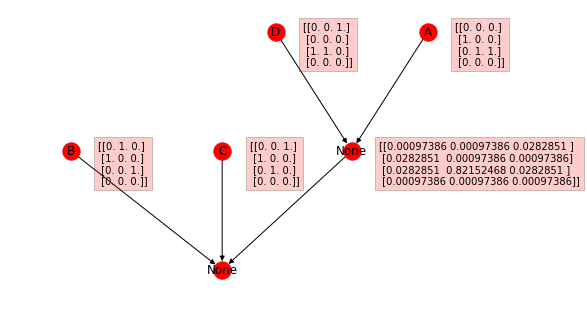

<Node object at 0x1a1b888b38: 'None' (None)>


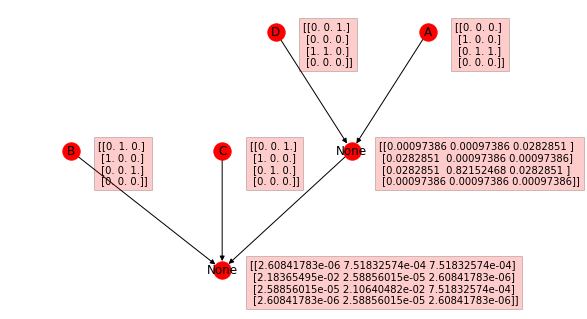

In [35]:
test_alignment = {"A": "CGG", "B": "CAG", "C": "CGA", "D":"GGA"}
node_probs = {}
node_probs = set_terminal_probs(trees[0], node_probs, test_alignment)
for node in trees[0].postorder_node_iter():
    if not node.is_leaf():
        print(node)
        node_probs = calculate_nucleotide_probs(node, node_probs, 3)
        plot_rooted_tree(trees[0], node_probs)

We also create a wrapper function for doing this on every node on the tree, similar to the code block above.

In [49]:
def set_inner_probs(tree, node_probs, alignment_length):
    for node in tree.postorder_node_iter():
        if not node.is_leaf():
            node_probs = calculate_nucleotide_probs(node, node_probs, alignment_length)
        #if node_probs_bool[node] == False:
            #node_probs_bool[node] = True
            
    return node_probs

To find the likelihood for the entire tree we sum over columns in the root and mutliply by the . Next, to find the likelihood for the tree we have to multiply the sum of likelihoods for each site. However, this means that we will multiply many small numbers and this can lead to something called underflow, where the computer is no longer able to represent the number in the memory. Instead of doing the multiplication we switch to log-likelihoods and sum the site likelihoods.

In [39]:
column_log_likelihood = 0.25 * node_probs[trees[0].seed_node].sum(axis=0)
tree_log_likelihood = np.sum(np.log(column_log_likelihood))
print(column_log_likelihood)
print(tree_log_likelihood)

[-5.20904117 -5.20904117 -7.88268067]
-18.30076301976183


One parameter that we need to pass to these functions are the length of the alignment. The function below is a quick way to check that all sequences in the alignment are of the same length and returning the length of the alignment.

In [116]:
def get_alignment_length(alignment):
    seq_lengths = [len(seq) for taxa, seq in alignment.items()]
    if len(set(seq_lengths)) == 1:
        return seq_lengths[0]
    else:
        print('All sequence in the alignment is not of equal length')
        return False

We can test the function by creating a test alignment with two sequences with alignments of length 5.

In [129]:
test_alignment = {"A":"ACTTG", "B":"ACTTC"} 
print(get_alignment_length(test_alignment))

5


Now we have come to the final step before we can combine all steps together. This is the optimization of the branch lengths. For this we will use the Brent's method included in the scipy-package. We define a wrapper function that updates the branch length and update the log likelihood of the tree and this is the function we want to maximize.
When we have found the branch length that maximize we return the updated likelihoods.

In [66]:
def optimize_length(node, node_probs, aln_length, tree):
    optimize.fminbound(wrapper, 0, 2, xtol=0.01, args=(node_probs, aln_length, tree))
    node_probs  = set_inner_probs(tree, node_probs, aln_length)
    return node_probs

In [132]:
def wrapper(node_length, node_probs, aln_length, tree):
    node.edge_length = node_length
    tmp_node_probs = set_inner_probs(tree, node_probs, aln_length)
    tree_likelihood = -1 *np.sum(np.log(0.25 * tmp_node_probs[tree.seed_node].sum(axis=0)))
    
    return tree_likelihood

And here is the function that loops over the nodes that we want to update the branch length for. Changing the branch length of one node can affect what's the best branch length for a sibling node, so after we have update one node, we rerun the optimization on all previous nodes we visit.

In [ ]:
def branch_optimization(nodes, node_probs, aln_length, tree):
    for j, node in enumerate(nodes):
        node_probs = optimize_length(node, node_probs, aln_length, tree)
        for prev_node in nodes[:j-1]:
            node_probs = optimize_length(node, node_probs, aln_length, tree)
    
    return node_probs

Now we can combine all the steps together. We first read the alignment and check that all sequences are of equal length. We pass the list of the taxa to the function that generate all possible trees. For each tree, we assign the likelihoods, first to the leaf-nodes and then to the internal nodes and calculate the log-likelihood for the tree. After this we do one round of branch lenght optimization and calculate a new log-likelihood. Following this we continue to do branch length optimization until we reach convergence or the maximum number of optimization rounds we want to run.

In [258]:
# Warning, very slow step. We can make it faster by changing the 'full' to
# an integer n to include only first n bases of the alignment
#alignment = {"A":'ATGGGTAAGATTG', "B":'ATGGCTAAGAGTT', "C":'ATGCGTTAGAGTT', "D":'ATGCGTTAGTTTG', "E": 'ATGGCTAAGATAT', "F": 'ATGTTTAAGATAT'}
alignment = read_msa('./data/alpha_globin_full.fasta', 20)
print(alignment)
aln_length = get_alignment_length(alignment)
taxon = [taxa for taxa in alignment.keys()]



# Create all trees
tree_list = create_all_trees(taxons=taxon)

# Optimize branch lengths
epsilon = 0.001  
max_opt_iterations = 5 
starting_tree_scores = []
best_trees = []  # store tree with optimized branch lengths
best_tree_scores = []  # store the score for tree with optimized branch lengths


for i in range(len(tree_list)):
    
    tree = tree_list[i].extract_tree()
    
    # First set the observed likelihoods
    node_probs = {}
    node_probs = set_terminal_probs(tree, node_probs, alignment)
    
    # Set likelihoods in the internal nodes
    node_probs = set_inner_probs(tree, node_probs, aln_length)
    
    # Calulate log-likelihood for tree without branch length optimizations
    log_likelihoods = np.sum(np.log(0.25 * node_probs[tree.seed_node].sum(axis=0)))
    starting_tree_scores.append(log_likelihoods)
    prev_likelihoods = log_likelihoods
    
    # Extract nodes for branch optimizatoins,
    # we don't want optimize the root since it doesn't have any parent node.
    nodes = list(tree.postorder_node_iter())
    nodes = [n for n in nodes if n != tree.seed_node]
    
    # First round of branch optimization
    for j, node in enumerate(nodes):
        node_probs = optimize_length(node, node_probs, aln_length, tree)
        for prev_node in nodes[:j-1]:
            node_probs = optimize_length(node, node_probs, aln_length, tree)
    best_likelihoods = np.sum(np.log(0.25 * node_probs[tree.seed_node].sum(axis=0)))
    
    opt_counter = 0  # count optimization rounds
    best_tree = None
    
    # Continue branch optimization until likelihood converge or max optimization rounds are reached
    while opt_counter < max_opt_iterations:
        print(opt_counter)
        print(prev_likelihoods)
        print(best_likelihoods)
        
        # Set new best tree
        if prev_likelihoods > best_likelihoods:  
            best_likelihoods = prev_likelihoods
            best_tree = tree.extract_tree()
            
        # Optimize branch length
        for j, node in enumerate(nodes):
            node_probs = optimize_length(node, node_probs, aln_length, tree)
            for prev_node in nodes[:j-1]:
                node_probs = optimize_length(node, node_probs, aln_length, tree)
        
        # log-likelihoods for new branch lengths
        prev_likelihoods = np.sum(np.log(0.25 * node_probs[tree.seed_node].sum(axis=0)))
        
        # Check for convergence
        if abs(prev_likelihoods - best_likelihoods) < epsilon:
            break
        opt_counter += 1
    
    print('Tree ' + str(i + 1))
    print('Opt-rounds: ' + str(opt_counter + 1))
    print('Non-optimal:' + str(log_likelihoods))
    print('Optimal:' + str(best_likelihoods))
        
    best_trees.append(best_tree)
    best_tree_scores.append(best_likelihoods)
    

{'>ENA|CAA24095|CAA24095.1': 'ATGGTGCTCTCTGGGGAAGA', '>ENA|BAA20512|BAA20512.1': 'ATGAGTCTCTCTGATAAGGA', '>ENA|CAA23748|CAA23748.1': 'ATGGTGCTGTCTCCTGCCGA', '>ENA|CAB56829|CAB56829.1': 'ATGGTGCTGTCTGCCGCCGA', '>ENA|CAA28435|CAA28435.1': 'ATGTCTCTGACCAGGACTGA'}
0
-111.91155661304522
-100.54300000304218
1
-100.24522864447586
-100.54300000304218
2
-100.23839825312216
-100.24522864447586
Tree 1
Opt-rounds: 3
Non-optimal:-111.91155661304522
Optimal:-100.23839825312216
0
-118.29787031853016
-104.36288321892242
1
-101.5278348036296
-104.36288321892242
2
-101.29681123984875
-101.5278348036296
3
-101.26168548526319
-101.29681123984875
4
-101.25121341532629
-101.26168548526319
Tree 2
Opt-rounds: 6
Non-optimal:-118.29787031853016
Optimal:-101.25121341532629
0
-117.88831044751761
-101.56856832990745
1
-101.24517642496679
-101.56856832990745
2
-101.22001272996086
-101.24517642496679
3
-101.21677355690939
-101.22001272996086
4
-101.21993124124715
-101.21677355690939
Tree 3
Opt-rounds: 6
Non-optimal:

In [259]:
def write_trees(path, trees):
    f = open(output, 'w')
    for tree in trees:
        f.write(str(tree) + ';\n')
    f.close()

In [269]:
def write_msa(path, alignment):
    with open(path, 'w') as f:
        for k in alignment.keys():
            f.write(k + '\n')
            f.write(alignment[k] + '\n')

In [272]:
output_msa = './data/used_alignment.msa'
write_msa(output_msa, alignment)

In [273]:
print(best_tree_scores)
(m,i) = max((v,i) for i,v in enumerate(best_tree_scores))
print(m)
print(best_trees)
print(best_trees[i])
best_trees_output = './data/best_trees.tree'
write_trees(best_trees_output, best_trees)

starting_trees_output = './data/starting_trees.tree'
write_trees(starting_trees_output, tree_list)

[-100.23839825312216, -101.25121341532629, -101.21677355690939, -100.603002097856, -101.21872606924785, -101.34672586322375, -100.7524266503561, -101.40395149325533, -100.36800908685015, -101.36000842215749, -98.71366841258764, -97.9009799501958, -98.055116085692, -98.6442894800343, -98.69565972749652]
-97.9009799501958
[<Tree object at 0x1a1bc87198>, <Tree object at 0x1a1c30e6a0>, <Tree object at 0x1a1bfb7320>, <Tree object at 0x1a1bdfa358>, <Tree object at 0x1a1c1974a8>, <Tree object at 0x1a1bdfb6a0>, <Tree object at 0x1a1c5e4a58>, <Tree object at 0x1a1bfacb70>, <Tree object at 0x1a1c73a5c0>, <Tree object at 0x1a1b850c50>, <Tree object at 0x1a1bc9a208>, <Tree object at 0x1a1bedfba8>, <Tree object at 0x1a1bedfe80>, <Tree object at 0x1a1bfd0630>, <Tree object at 0x1a1bfd0b00>]
((>ENA|CAA23748|CAA23748.1:0.10388076747058253,>ENA|CAB56829|CAB56829.1:0.004797285301853457):0.2985985823344534,>ENA|CAA24095|CAA24095.1:0.004797285301853457,(>ENA|BAA20512|BAA20512.1:0.24733768249488733,>ENA|CA

How good are theese results. We can compare our trees to what a state of art software like RAxML would produce. To run the following conde RAxML must be installed on your system, you can downloaded the software from [here].  We can first write our starting trees to a file and then we can use the evaluate function in RAxML to see what log-likelihood values they calculate for the trees and how well they can optimize the branch lengths. To get the results we grep the lines from the logging file.

In [285]:
%%bash
cat ./data/used_alignment.msa
sed 's/>//g' ./data/starting_trees.tree > ./data/starting_trees_edit.tree
cat ./data/starting_trees_edit.tree
./data/raxml-ng --evaluate --msa ./data/used_alignment.msa --model JC --prefix ./data/compare --threads 2  --tree ./data/starting_trees_edit.tree --redo
grep 'initial' ./data/compare.raxml.log > ./data/initial_log_likelihoods.txt
grep 'final' ./data/compare.raxml.log > ./data/final_log_likelihoods.txt

>ENA|CAA24095|CAA24095.1
ATGGTGCTCTCTGGGGAAGA
>ENA|BAA20512|BAA20512.1
ATGAGTCTCTCTGATAAGGA
>ENA|CAA23748|CAA23748.1
ATGGTGCTGTCTCCTGCCGA
>ENA|CAB56829|CAB56829.1
ATGGTGCTGTCTGCCGCCGA
>ENA|CAA28435|CAA28435.1
ATGTCTCTGACCAGGACTGA
(ENA|CAA23748|CAA23748.1:0.1,(ENA|CAA24095|CAA24095.1:0.1,ENA|CAB56829|CAB56829.1:0.1):0.1,(ENA|BAA20512|BAA20512.1:0.1,ENA|CAA28435|CAA28435.1:0.1):0.1);
((ENA|CAA24095|CAA24095.1:0.1,ENA|CAB56829|CAB56829.1:0.1):0.1,ENA|BAA20512|BAA20512.1:0.1,(ENA|CAA23748|CAA23748.1:0.1,ENA|CAA28435|CAA28435.1:0.1):0.1);
(ENA|BAA20512|BAA20512.1:0.1,ENA|CAA23748|CAA23748.1:0.1,((ENA|CAA24095|CAA24095.1:0.1,ENA|CAB56829|CAB56829.1:0.1):0.1,ENA|CAA28435|CAA28435.1:0.1):0.1);
(ENA|BAA20512|BAA20512.1:0.1,ENA|CAA23748|CAA23748.1:0.1,(ENA|CAB56829|CAB56829.1:0.1,(ENA|CAA24095|CAA24095.1:0.1,ENA|CAA28435|CAA28435.1:0.1):0.1):0.1);
(ENA|BAA20512|BAA20512.1:0.1,ENA|CAA23748|CAA23748.1:0.1,(ENA|CAA24095|CAA24095.1:0.1,(ENA|CAB56829|CAB56829.1:0.1,ENA|CAA28435|CAA28435.1:0.1):0.1):0

Here is a small function to read the files with the log-likelihood values.

In [286]:
def read_logL_files(path):
    log_likelihoods = []
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            line = line.split(" ")
            logL = float(line[-1])
            log_likelihoods.append(logL)

    return log_likelihoods

Now we read the results obtained from RAxML and plot it against the result we obtain with the functions implemented in our notebook.

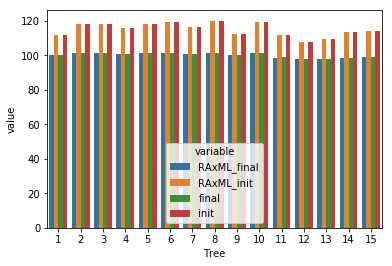

In [289]:
raxml_final_logL = read_logL_files('./data/final_log_likelihoods.txt')
raxml_initial_logl = read_logL_files('./data/initial_log_likelihoods.txt')
raw_data = {'RAxML_init':raxml_initial_logl, 'RAxML_final':raxml_final_logL, 'init':starting_tree_scores, 'final':best_tree_scores}
for k in raw_data.keys():
    posLog = [-i for i in raw_data[k]]
    raw_data[k] = posLog
raw_df = pd.DataFrame.from_dict(raw_data)
raw_df['Tree'] = raw_df.index + 1
plotting_data = pd.melt(raw_df, id_vars=['Tree'])
plotting_data
sns.barplot(x='Tree', y='value', hue='variable', data=plotting_data)

plt.show()


In [288]:
%%bash
wc -l ./data/starting_trees.tree

      15 ./data/starting_trees.tree
